In [82]:
import os
import sys
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneOut

%matplotlib inline

# Indium foil activation experiment

## 1. Calibration of the NaI detector

- Load spectrum of Co60, Cs137, Eu152, and BG
- Normalize spectra with the total counting time
- Fit gaussian function to the peaks
- Energy calibration: bin vs energy
- Plot the calibrated spectra



## Settings

In [53]:
spectrum_folder = '/Users/hkromer/02_PhD/02_Data/03.Indium/2019/' # calibration is date.02.Calib

## Functions


### Plot the spectra

**INPUT**
- df 
    - dataframe that contains the spectra bins in columns
    - each row of the df corresponds to one bin
- suffix
    - for the filename
    - if the length of the string is greater than 0, the string will be added before the png
    - default behavior is to write only spectrum.NAMEOFISOTOPE.ong
- figout
    - path where the figure will be saved in
    
**OUTPUT**
- plots in this notebook
- saves the figures in the path: figout/spectrum.(...).png

In [54]:
def plot_spectra(df, suffix='', figout=spectrum_folder):
    for fname in calib_specs:
        re_isotope = re.findall(r'02\.Calib\.(\w+)\.\d', fname)
        if len(re_isotope) > 0:
            isotope = re_isotope[0]
        else:
            isotope = 'BG'
        plt.scatter(df.index, df[isotope], s=2)
        plt.errorbar(df.index, df[isotope], np.sqrt(df['Co60'])/2, xerr=None, fmt='none', ecolor="red", elinewidth=0.25)
        # plt.yscale('log')
        plt.title(f'Spectrum for isotope {isotope}')
        plt.xlabel('bin')
        plt.ylabel('Counts')
        plt.xlim(0, 10000)
        plt.ylim(1e0, 1e6)
        plt.grid()
        if len(suffix) > 0:
            plt.savefig(f'{figout}/spectrum.{isotope}.{suffix}.png', dpi=600)
        else:
            plt.savefig(f'{figout}/spectrum.{isotope}.png', dpi=600)
        plt.show()
        plt.close()


## 1.1 Load spectrum of Co60, Cs137, Eu152, and BG

In [55]:
# List the spectrums in the 3folder
all_specs = os.listdir(spectrum_folder)

# select only the 02.Calib spectrums
calib_specs = [f'{spectrum_folder}/{f}' for f in all_specs if '02.Calib' in f]

# add the background spectrum
calib_specs.append(f'{spectrum_folder}/2019-03-14.04.BG.23hrs.Spe')

lst_df = [] # list of the dataframe for each file
for fname in calib_specs:
    with open(fname, 'r') as file:
        c = file.readlines()
        c = [s.strip() for s in c]
        c = c[12:-14]  # skip garbage at beginning and end
        file.close()
#     print(c[-5:])
    
    re_isotope = re.findall(r'02\.Calib\.(\w+)\.\d', fname)
    if len(re_isotope) > 0:
        isotope = re_isotope[0]
    else:
        isotope = 'BG'
    
    df_t = pd.DataFrame() # temporary df that contains this spectrum
    df_t[isotope] = np.asarray(c, dtype=float)
    lst_df.append(df_t)
    
df = pd.concat(lst_df, axis=1)
print(df.head())
print(df.info())
print(df.sum())

   Eu152  Co60  Cs137   BG
0    0.0   0.0    0.0  0.0
1    0.0   0.0    0.0  0.0
2    0.0   0.0    0.0  0.0
3    0.0   0.0    0.0  0.0
4    0.0   0.0    0.0  0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16384 entries, 0 to 16383
Data columns (total 4 columns):
Eu152    16384 non-null float64
Co60     16384 non-null float64
Cs137    16384 non-null float64
BG       16384 non-null float64
dtypes: float64(4)
memory usage: 512.1 KB
None
Eu152    97608772.0
Co60      6836748.0
Cs137    16736515.0
BG       11183521.0
dtype: float64


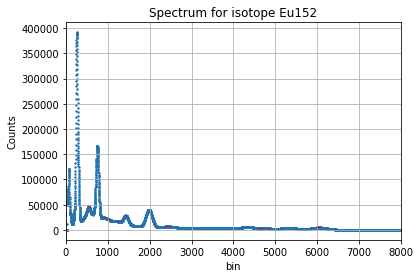

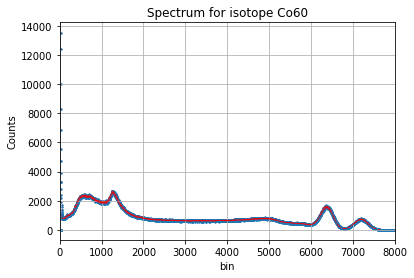

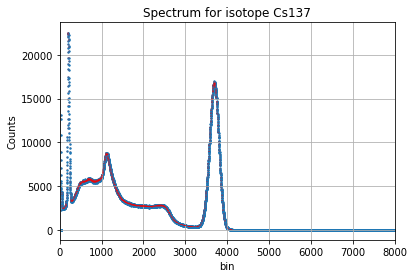

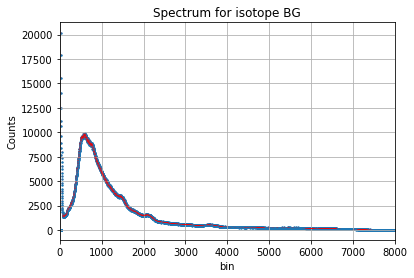

In [56]:
# plot the raw spectra
for fname in calib_specs:
    re_isotope = re.findall(r'02\.Calib\.(\w+)\.\d', fname)
    if len(re_isotope) > 0:
        isotope = re_isotope[0]
    else:
        isotope = 'BG'
    plt.scatter(df.index, df[isotope], s=2)
    plt.errorbar(df.index, df[isotope], np.sqrt(df[isotope])/2, xerr=None, fmt='none', ecolor="red", elinewidth=0.25)
    # plt.yscale('log')
    plt.title(f'Spectrum for isotope {isotope}')
    plt.xlabel('bin')
    plt.ylabel('Counts')
    plt.xlim(0, 8000)
    #plt.ylim(1e0, 1e6)
    plt.grid()
    
    plt.savefig(f'{spectrum_folder}/spectrum.{isotope}.png', dpi=600)

    plt.show()
    plt.close()

## 1.2 Normalize spectra with the total counting time

Take this from the labnotes!

In [57]:
# Co60, Cs137, Eu152, BG
meas_times = {'Isotope': ['Co60', 'Cs137', 'Eu152', 'BG'],
              'Real_time_s': [7272.74, 7322.34, 43837.48, 82880.1], 
              'Live_time_s': [7200, 7200, 43200, 82800]}


df_meas_times = pd.DataFrame(meas_times)

print(df_meas_times.head())

print(df.sum())

df_normalized = df.copy()
isotope = 'Co60'
for isotope in df_meas_times['Isotope']:
    counting_time = df_meas_times[ df_meas_times['Isotope'] == isotope ].Real_time_s.values[0]
    df_normalized[isotope] = df_normalized[isotope]/counting_time

print(df_normalized.sum())

  Isotope  Real_time_s  Live_time_s
0    Co60      7272.74         7200
1   Cs137      7322.34         7200
2   Eu152     43837.48        43200
3      BG     82880.10        82800
Eu152    97608772.0
Co60      6836748.0
Cs137    16736515.0
BG       11183521.0
dtype: float64
Eu152    2226.605453
Co60      940.051205
Cs137    2285.678485
BG        134.936143
dtype: float64


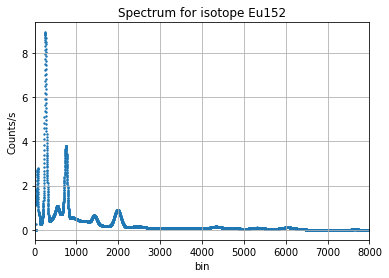

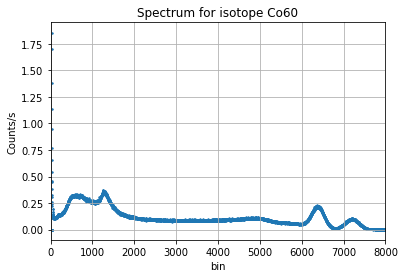

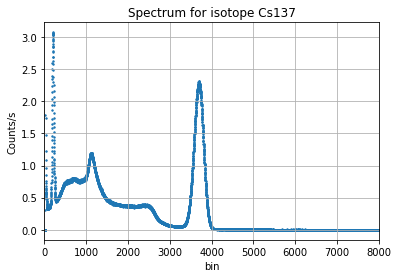

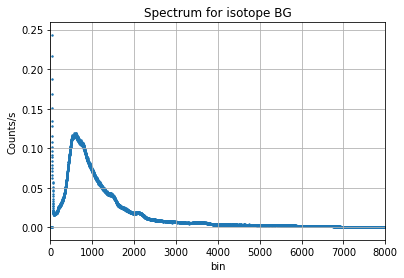

In [58]:
# plot the normalized spectra
for fname in calib_specs:
    re_isotope = re.findall(r'02\.Calib\.(\w+)\.\d', fname)
    if len(re_isotope) > 0:
        isotope = re_isotope[0]
    else:
        isotope = 'BG'
    plt.scatter(df_normalized.index, df_normalized[isotope], s=2)
    # plt.errorbar(df_normalized.index, df_normalized[isotope], np.sqrt(df_normalized[isotope])/2, xerr=None, fmt='none', ecolor="red", elinewidth=0.25)
    # plt.yscale('log')
    plt.title(f'Spectrum for isotope {isotope}')
    plt.xlabel('bin')
    plt.ylabel('Counts/s')
    plt.xlim(0, 8000)
    #plt.ylim(1e0, 1e1)
    plt.grid()
    plt.savefig(f'{spectrum_folder}/spectrum.{isotope}.normalized.png', dpi=600)

    plt.show()
    plt.close()

## 1.3 Fit gaussian function to the peaks

- set the region of the peaks by hand
- fit a gaussian to the region and record the parameters (A, x0, sigma) for each of the peaks


- Eu152 is taken from http://www.spectrumtechniques.com/wp-content/uploads/2016/12/Europium-152-Information-Sheet.pdf 
- Co60 is taken from http://www.spectrumtechniques.com/wp-content/uploads/2016/12/Cobalt-60-Information-Sheet.pdf

In [59]:
peak_regions = {'isotope': ['Co60', 'Co60', 'Cs137', 'Eu152', 'Eu152', 'Eu152', 'Eu152', 'Eu152', 'Eu152', 'Eu152'],
                'energy': [1173.237, 1332.501, 662, 121.7817, 244.6975, 344.2785, 778.904, 964.079, 1112.074, 1408.006],
                'intensity': [99.9736, 99.9856, 100, 28.58, 7.583, 26.5, 12.942, 14.605, 13.644, 21.005],
              'lower_bin_limit': [6200, 7000, 3200,  650, 1300, 1800, 4100, 5000, 5650, 7200], 
              'upper_bin_limit': [6600, 7500, 4200,  850, 1550, 2200, 4600, 5600, 6400, 8000]}

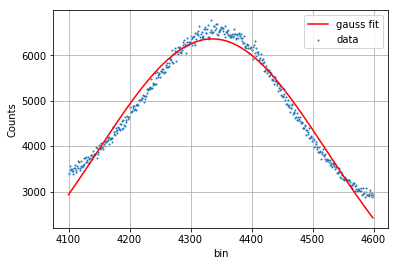

In [60]:
def gauss(x, a, x0, sigma):
    return a * np.exp(-(x-x0)**2/(2*sigma**2))

# test fit on Cs137
idx = [4100, 4600]
X = df.index.values[idx[0]: idx[1]]
Y = df['Eu152'].values[idx[0]: idx[1]]


n = len(X)
mean = np.sum(X)/n

A = np.max(X)

popt, pcov = curve_fit(gauss, X, Y, p0=[A/2, mean, mean], maxfev=10000)
A, x0, sigma = popt
plt.scatter(X, Y, s=1, label='data')
plt.plot(X, gauss(X, *popt), color="red", label='gauss fit')
plt.ylabel('Counts')
plt.xlabel('bin')
plt.grid()
plt.legend()
plt.show()

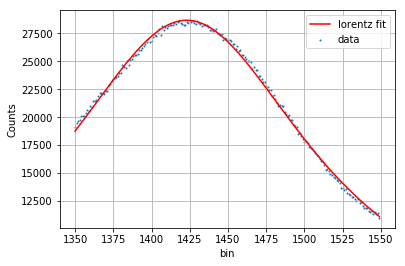

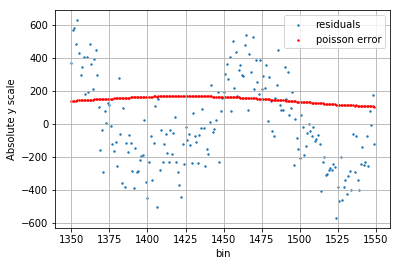

In [61]:
def lorentzian(x, x0, a, gam):
    return a * gam**2 / ( gam**2 + ( x - x0 )**2 )

# test fit on Cs137
idx = [1350, 1550]
X = df.index.values[idx[0]: idx[1]]
Y = df['Eu152'].values[idx[0]: idx[1]]


n = len(X)
mean = np.sum(X)/n

A = np.max(X)

popt, pcov = curve_fit(lorentzian, X, Y, p0=[mean, A/2, mean], maxfev=10000)
x0, A, gam = popt
plt.scatter(X, Y, s=1, label='data')
plt.plot(X, lorentzian(X, *popt), color="red", label='lorentz fit')
plt.ylabel('Counts')
plt.xlabel('bin')
plt.grid()
plt.legend()
plt.show()

# residuals
res = Y - lorentzian(X, *popt)

plt.scatter(X, res, label="residuals", s=2)
plt.scatter(X,np.sqrt(Y),color="red", label="poisson error", s=2)
plt.ylabel('Absolute y scale')
plt.xlabel('bin')
plt.grid()
plt.legend()
plt.show()

In [62]:
mean
x0

1422.9650868937176

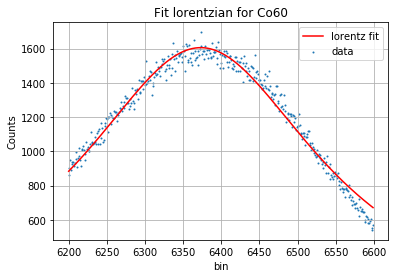

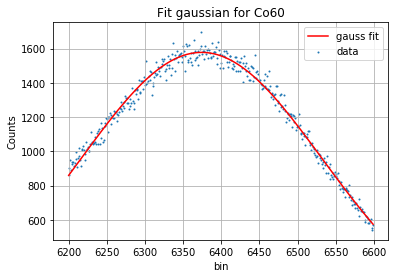

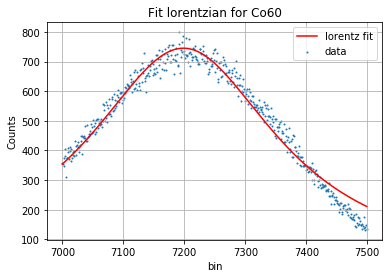

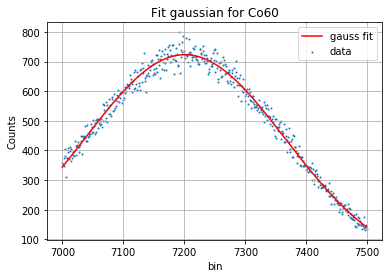

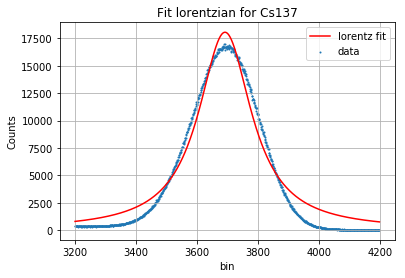

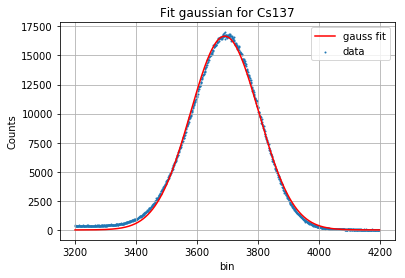

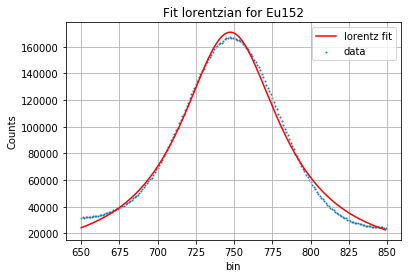

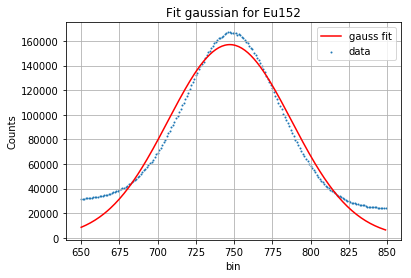

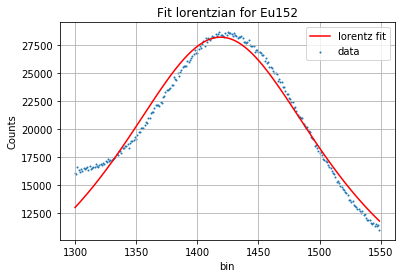

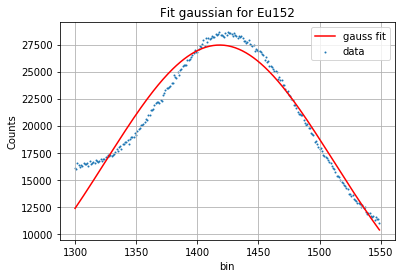

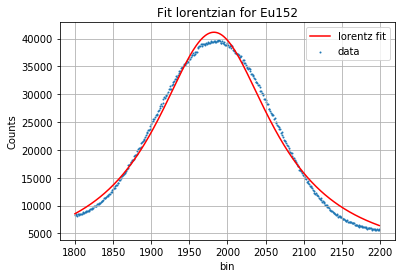

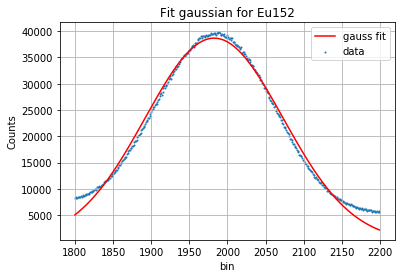

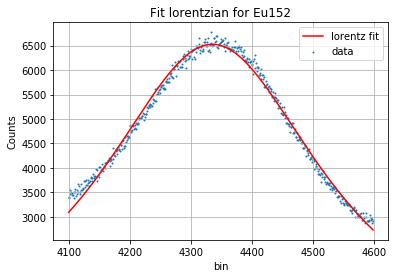

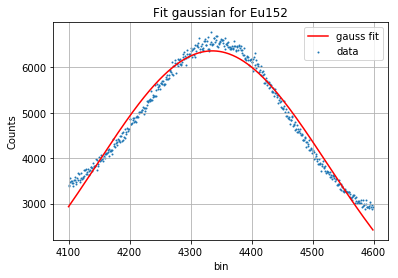

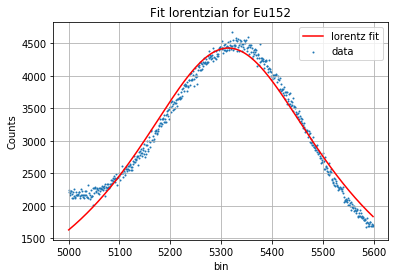

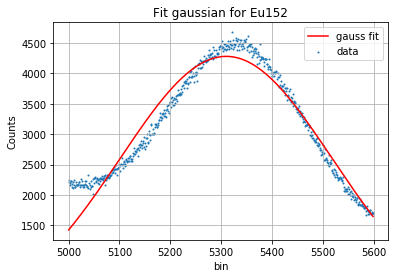

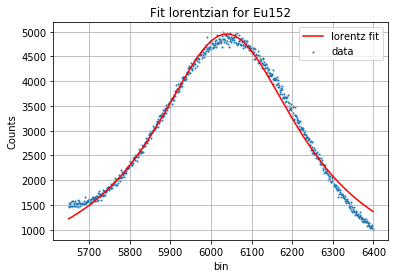

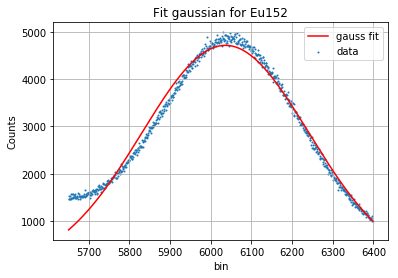

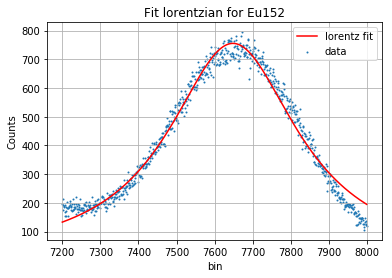

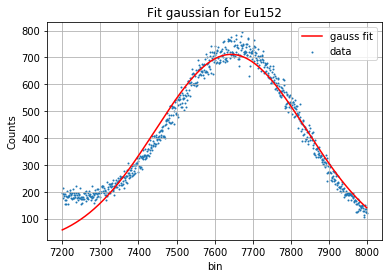

,isotope,energy,intensity,lower_bin_limit,upper_bin_limit,x0_lorentz,x0_gauss,A_lorentz,A_gauss,gam_lorentz,sigma_gauss
0,Co60,1173.2370,99.9736,6200,6600,6373.098730,6374.258932,1605.138235,1577.468569,191.541515,158.098621
1,Co60,1332.5010,99.9856,7000,7500,7198.589145,7201.070994,745.176089,723.288531,-188.926718,164.872971
2,Cs137,662.0000,100.0000,3200,4200,3692.186294,3691.216306,18060.377571,16659.901412,-105.710631,-111.941246
3,Eu152,121.7817,28.5800,650,850,747.447764,747.179301,170845.877655,156976.974582,-39.626205,-40.335418
4,Eu152,244.6975,7.5830,1300,1550,1419.095744,1418.319206,28193.510111,27450.300672,110.140488,-93.610445
5,Eu152,344.2785,26.5000,1800,2200,1982.198083,1982.472987,41130.399969,38646.684469,-93.245167,-90.548064
6,Eu152,778.9040,12.9420,4100,4600,4335.557150,4335.709711,6524.773469,6360.625183,-223.839207,-189.327370
7,Eu152,964.0790,14.6050,5000,5600,5314.099948,5309.993073,4429.951978,4276.950390,239.685037,-209.226311
8,Eu152,1112.0740,13.6440,5650,6400,6039.040836,6035.969749,4952.530414,4712.367730,-222.389861,206.009154
9,Eu152,1408.0060,21.0050,7200,8000,7647.949103,7642.979186,755.264117,711.587765,207.200932,197.662904


In [63]:
df_peaks = pd.DataFrame(peak_regions)

def fit_peaks(row):
    idx = [row['lower_bin_limit'], row['upper_bin_limit']]
    X = df.index.values[idx[0]: idx[1]]
    Y = df[row['isotope']].values[idx[0]: idx[1]]

    n = len(X)
    mean = np.sum(X)/n

    A = np.max(X)

    popt, pcov = curve_fit(lorentzian, X, Y, p0=[mean, A/2, mean], maxfev=10000)
    x0, A, gam = popt
    plt.scatter(X, Y, s=1, label='data')
    plt.plot(X, lorentzian(X, *popt), color="red", label='lorentz fit')
    plt.title(f'Fit lorentzian for {row.isotope}')
    plt.ylabel('Counts')
    plt.xlabel('bin')
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()

    x0_lorentz = x0
    A_lorentz = A
    gam_lorentz = gam
              
    popt, pcov = curve_fit(gauss, X, Y, p0=[A/2, mean, mean], maxfev=10000)
    A, x0, sigma = popt
    plt.scatter(X, Y, s=1, label='data')
    plt.plot(X, gauss(X, *popt), color="red", label='gauss fit')
    plt.title(f'Fit gaussian for {row.isotope}')
    plt.ylabel('Counts')
    plt.xlabel('bin')
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()

    x0_gauss = x0
    A_gauss = A
    sigma_gauss = sigma
    return x0_lorentz, x0_gauss, A_lorentz, A_gauss, gam_lorentz, sigma_gauss
    
df_peaks['x0_lorentz'], df_peaks['x0_gauss'], df_peaks['A_lorentz'], df_peaks['A_gauss'], df_peaks['gam_lorentz'], df_peaks['sigma_gauss'] = zip(*df_peaks.apply(lambda x: fit_peaks(x), axis=1))
df_peaks

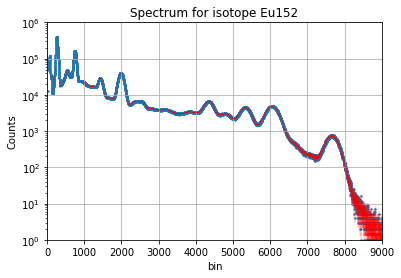

In [64]:
# plot one spectrum 
isotope = 'Eu152'
s = df.loc[:,isotope]

#  one spectrum 
plt.scatter(s.index, s.values, s=2)
plt.errorbar(s.index, s.values, np.sqrt(s.values)/2, xerr=None, fmt='none', ecolor="red", elinewidth=0.25)
plt.yscale('log')
plt.title(f'Spectrum for isotope {isotope}')
plt.xlabel('bin')
plt.ylabel('Counts')
plt.xlim(0, 9000)
plt.ylim(1e0, 1e6)
plt.grid()


plt.show()
plt.close()

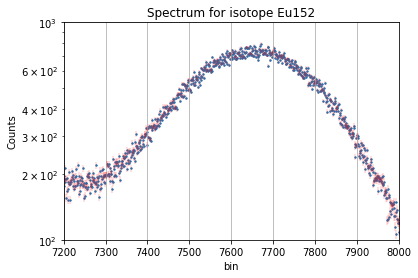

In [65]:
# plot one spectrum 
isotope = 'Eu152'
s = df.loc[:,isotope]

#  one spectrum 
plt.scatter(s.index, s.values, s=2)
plt.errorbar(s.index, s.values, np.sqrt(s.values)/2, xerr=None, fmt='none', ecolor="red", elinewidth=0.25)
plt.yscale('log')
plt.title(f'Spectrum for isotope {isotope}')
plt.xlabel('bin')
plt.ylabel('Counts')
plt.xlim(7200, 8000)
plt.ylim(1e2, 1e3)
plt.grid()


plt.show()
plt.close()

Doing isotope: Co60


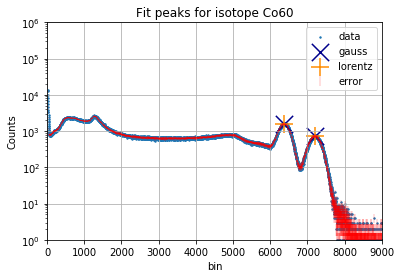

Doing isotope: Cs137


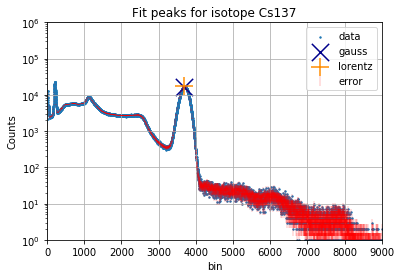

Doing isotope: Eu152


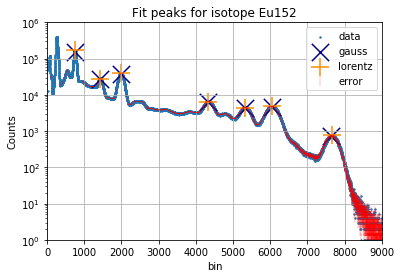

In [66]:
# plot one spectrum with peaks
for isotope in df_peaks['isotope'].unique():
    print(f'Doing isotope: {isotope}')
    this_peaks = df_peaks[ df_peaks['isotope'] == isotope ]


    s = df.loc[:,isotope]

    #  one spectrum 
    plt.scatter(s.index, s.values, s=2, label='data')

    # gaussian peaks
    plt.scatter(this_peaks['x0_gauss'], this_peaks['A_gauss'], color='darkblue', marker='x', s=300, label='gauss')

    # lorentzian peaks
    plt.scatter(this_peaks['x0_lorentz'], this_peaks['A_lorentz'], color='darkorange', marker='+', s=300, label='lorentz')



    plt.errorbar(s.index, s.values, np.sqrt(s.values)/2, xerr=None, fmt='none', ecolor="red", elinewidth=0.25, label='error')
    plt.yscale('log')
    plt.title(f'Fit peaks for isotope {isotope}')
    plt.xlabel('bin')
    plt.ylabel('Counts')
    plt.xlim(0, 9000)
    plt.ylim(1e0, 1e6)
    plt.legend()
    plt.grid()
    plt.savefig(f'{spectrum_folder}/spectrum.withPeaks.isotope_{isotope}.png', dpi=600)

    plt.show()
    plt.close()

## 1.4 Energy calibration: energy vs bin

- Take the Co peaks and do a calibration
- Take all the Eu peaks and do a calibration




In [67]:
df_peaks

,isotope,energy,intensity,lower_bin_limit,upper_bin_limit,x0_lorentz,x0_gauss,A_lorentz,A_gauss,gam_lorentz,sigma_gauss
0,Co60,1173.2370,99.9736,6200,6600,6373.098730,6374.258932,1605.138235,1577.468569,191.541515,158.098621
1,Co60,1332.5010,99.9856,7000,7500,7198.589145,7201.070994,745.176089,723.288531,-188.926718,164.872971
2,Cs137,662.0000,100.0000,3200,4200,3692.186294,3691.216306,18060.377571,16659.901412,-105.710631,-111.941246
3,Eu152,121.7817,28.5800,650,850,747.447764,747.179301,170845.877655,156976.974582,-39.626205,-40.335418
4,Eu152,244.6975,7.5830,1300,1550,1419.095744,1418.319206,28193.510111,27450.300672,110.140488,-93.610445
5,Eu152,344.2785,26.5000,1800,2200,1982.198083,1982.472987,41130.399969,38646.684469,-93.245167,-90.548064
6,Eu152,778.9040,12.9420,4100,4600,4335.557150,4335.709711,6524.773469,6360.625183,-223.839207,-189.327370
7,Eu152,964.0790,14.6050,5000,5600,5314.099948,5309.993073,4429.951978,4276.950390,239.685037,-209.226311
8,Eu152,1112.0740,13.6440,5650,6400,6039.040836,6035.969749,4952.530414,4712.367730,-222.389861,206.009154
9,Eu152,1408.0060,21.0050,7200,8000,7647.949103,7642.979186,755.264117,711.587765,207.200932,197.662904


Function to do linear regression with LOOCV.

In [154]:
def lin_reg(X, y, bool_plot=True):
    slopes = []
    intercepts = []
    MSEs = []
    r2s = []
    residuals = []
    
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    for train_index, test_index in loo.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        #print(X_train, X_test, y_train, y_test)

        # reshape
        X_train = X_train.reshape(-1, 1)
        X_test = X_test.reshape(-1, 1)
#         print(X_train)

        # Create linear regression object
        regr = linear_model.LinearRegression()

        # Train the model using the training sets
        regr.fit(X_train, y_train)

        # Make predictions using the testing set
        y_pred = regr.predict(X_test)

        # The coefficients
#         print('Coefficients: \n', regr.coef_)
#         print('Intercept: \n', regr.intercept_)
        # The mean squared error
        MSE = mean_squared_error(y_test, y_pred)
#         print("Mean squared error: %.2f"
#               % MSE)
        # Explained variance score: 1 is perfect prediction
        r2 = r2_score(y_test, y_pred)
#         print('Variance score: %.2f' % r2)

        residual = np.abs(y_test-y_pred)[0]

        plt.scatter(X_train, y_train, color='blue', label='data')
        x = np.arange(0, 9000+100, 100)
        slope = regr.coef_[0]

        intercept = regr.intercept_

        plt.plot(x, x*slope+intercept, color='black', label='fit')
        plt.scatter(X_test, y_test, color='red', label='validation_point')
        plt.xlabel('bins')
        plt.legend()
        plt.ylabel('energy [keV]')
        plt.grid()
        if bool_plot == True:
            plt.show()
            plt.close()
        else:
            plt.close()

        MSEs.append(MSE)
        r2s.append(r2)
        slopes.append(slope)
        intercepts.append(intercept)
        residuals.append(residual)

    return (MSEs, r2s, slopes, intercepts, residuals)


## Do lin reg with Gaussian and with Lorentzian

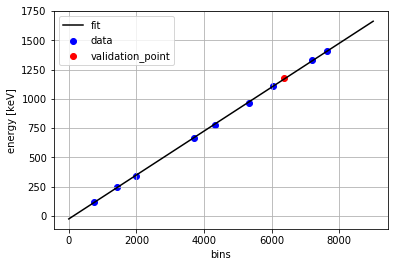

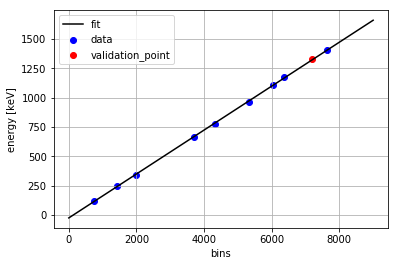

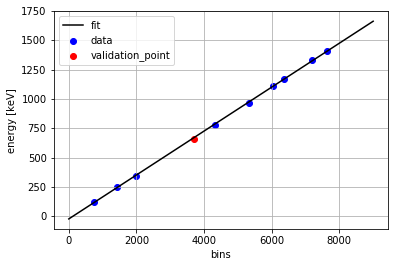

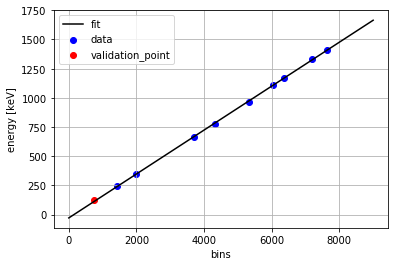

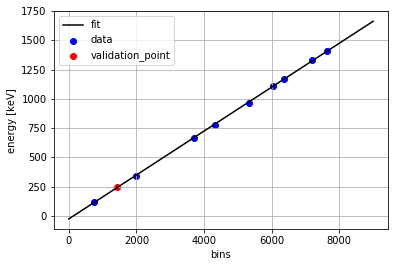

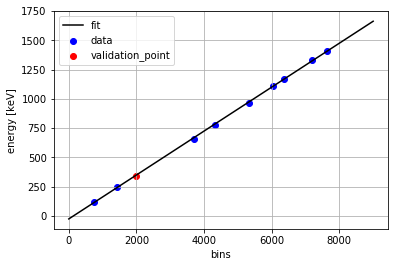

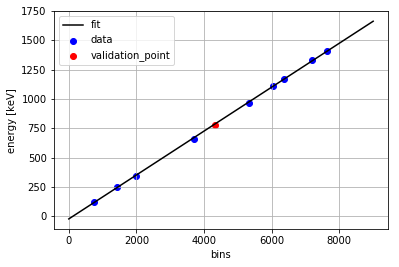

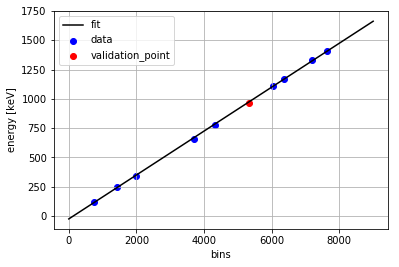

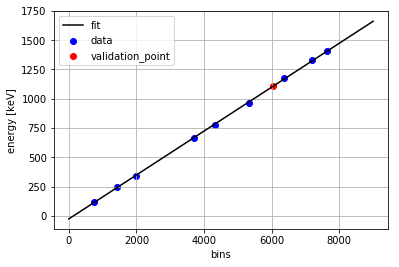

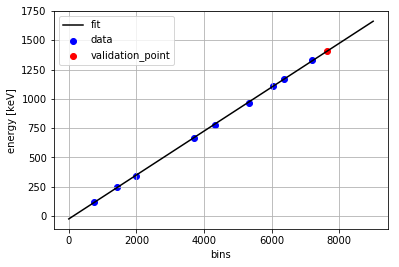

In [185]:
X = df_peaks['x0_lorentz'].values
y = df_peaks['energy'].values

MSEs_lorentz, r2s_lorentz, slopes_lorentz, intercepts_lorentz, residuals_lorentz = lin_reg(X, y, bool_plot=True)

X = df_peaks['x0_gauss'].values
y = df_peaks['energy'].values

MSEs_gauss, r2s_gauss, slopes_gauss, intercepts_gauss, residuals_gauss = lin_reg(X, y, bool_plot=False)

Histogram of slopes and intercept

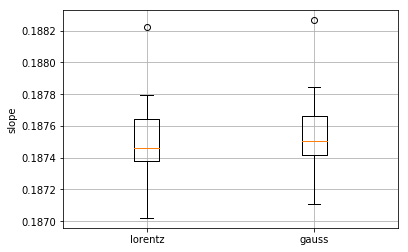

In [156]:
data = [slopes_lorentz, slopes_gauss]
# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot(data)
# plt.boxplot(data1,0,'',positions=x-100,widths=150)
# plt.boxplot(data2,0,'',positions=x+100,widths=150)

plt.xticks([1, 2], ['lorentz', 'gauss'])
plt.grid()
plt.ylabel('slope')
plt.show()

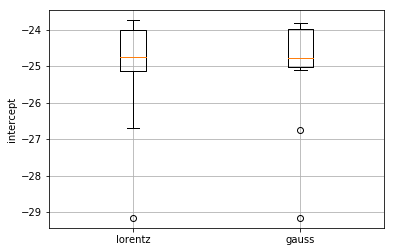

In [157]:
data = [intercepts_lorentz, intercepts_gauss]
# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot(data)
# plt.boxplot(data1,0,'',positions=x-100,widths=150)
# plt.boxplot(data2,0,'',positions=x+100,widths=150)

plt.xticks([1, 2], ['lorentz', 'gauss'])
plt.grid()
plt.ylabel('intercept')
plt.show()

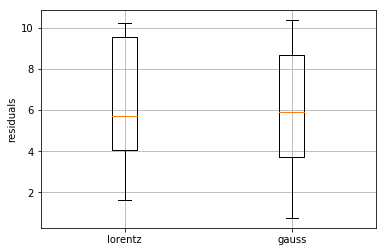

In [158]:
data = [residuals_lorentz, residuals_gauss]
# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot(data)
# plt.boxplot(data1,0,'',positions=x-100,widths=150)
# plt.boxplot(data2,0,'',positions=x+100,widths=150)

plt.xticks([1, 2], ['lorentz', 'gauss'])
plt.grid()
plt.ylabel('residuals')
plt.show()

The plots show that the found slopes, intercept and residuals do not change much on the scale of the y axis. The LOOCV does not show a significant deviation for the data.

Relative differences between the two fits

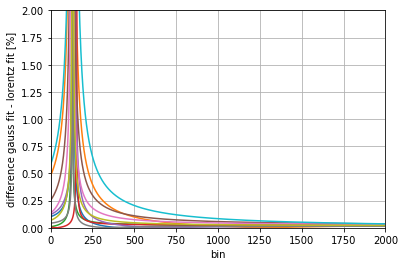

In [182]:
x = np.arange(0, 9000+1, 1)
for slope_g, slope_l, intercept_g, intercept_l in zip(slopes_gauss, slopes_lorentz, intercepts_gauss, intercepts_lorentz):
    y_g = slope_g*x+intercept_g
    y_l = slope_l*x+intercept_l
    rel_diff_gl = np.abs(100*(y_g - y_l)/y_g)
    
    plt.plot(x, rel_diff_gl)

plt.grid()
plt.ylim(0, 2)
plt.xlim(0, 2000)
plt.xlabel('bin')
plt.ylabel('difference gauss fit - lorentz fit [%]')
plt.show()  


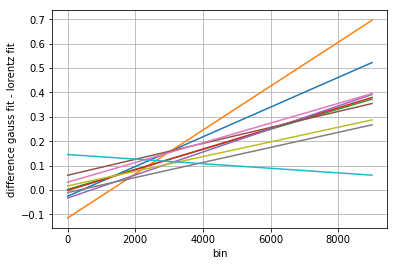

In [184]:
x = np.arange(0, 9000+1, 1)
for slope_g, slope_l, intercept_g, intercept_l in zip(slopes_gauss, slopes_lorentz, intercepts_gauss, intercepts_lorentz):
    y_g = slope_g*x+intercept_g
    y_l = slope_l*x+intercept_l
    diff_gl = (y_g - y_l)
    
    plt.plot(x, diff_gl)

plt.grid()

plt.xlabel('bin')
plt.ylabel('difference gauss fit - lorentz fit')
plt.show()  


Perform the linear regression with the full dataset. Careful! There is no distinction between test and training set!

First done with gaussian points, then lorentzian

*********
GAUSSIAN
*********
Coefficients: 
 0.1875610623303195
intercept: 
 -24.976744857061135
Mean squared error: 30.54
Variance score: 1.00


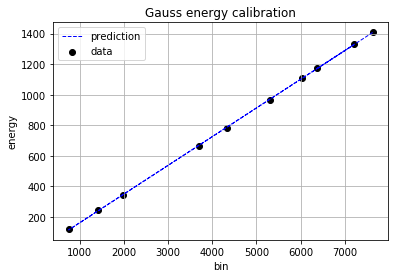

In [200]:
print('*********')
print('GAUSSIAN')
print('*********')

X = df_peaks['x0_gauss'].values
y = df_peaks['energy'].values

X = X.reshape(-1, 1)
# Train the model using the training sets
regr.fit(X, y)

# Make predictions using the testing set
y_pred = regr.predict(X)

# The coefficients
intercept = regr.intercept_
slope = regr.coef_[0]
print('Coefficients: \n', slope)
print('intercept: \n', intercept)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y, y_pred))

# Plot outputs
# Plot outputs
plt.scatter(X, y,  color='black', label='data')
plt.plot(X, y_pred, color='blue', linewidth=1, linestyle='--', label='prediction')
plt.title('Gauss energy calibration')
plt.grid()
plt.xlabel('bin')
plt.ylabel('energy')
plt.legend()

plt.savefig(f'{spectrum_folder}/energy_calibration.gauss.png', dpi=600)
plt.show()
intercept_gauss = intercept
slope_gauss = slope




*********
Lorentz
*********
Coefficients: 
 0.18752026768618693
intercept: 
 -24.983503856926177
Mean squared error: 32.00
Variance score: 1.00


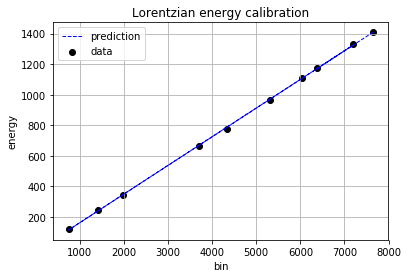

In [201]:
print('*********')
print('Lorentz')
print('*********')


X = df_peaks['x0_lorentz'].values
y = df_peaks['energy'].values

X = X.reshape(-1, 1)

# Train the model using the training sets
regr.fit(X, y)

# Make predictions using the testing set
y_pred = regr.predict(X)

# The coefficients
intercept = regr.intercept_
slope = regr.coef_[0]
print('Coefficients: \n', slope)
print('intercept: \n', intercept)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y, y_pred))

# Plot outputs
plt.scatter(X, y,  color='black', label='data')
plt.plot(X, y_pred, color='blue', linewidth=1, linestyle='--', label='prediction')
plt.title('Lorentzian energy calibration')
plt.grid()
plt.xlabel('bin')
plt.ylabel('energy')
plt.legend()


plt.savefig(f'{spectrum_folder}/energy_calibration.lorentz.png', dpi=600)
plt.show()
intercept_lorentz = intercept
slope_lorentz = slope


## 1.5 Plot the calibrated spectra

In [195]:
df['Energy_gauss'] = df.index*slope_gauss+intercept_gauss
df.head()

,Eu152,Co60,Cs137,BG,Energy_gauss
0,0.0,0.0,0.0,0.0,-24.976745
1,0.0,0.0,0.0,0.0,-24.789184
2,0.0,0.0,0.0,0.0,-24.601623
3,0.0,0.0,0.0,0.0,-24.414062
4,0.0,0.0,0.0,0.0,-24.226501


Doing isotope: Co60


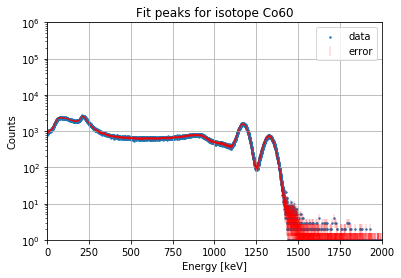

Doing isotope: Cs137


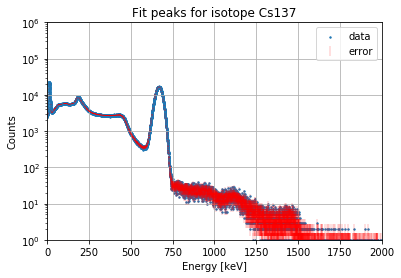

Doing isotope: Eu152


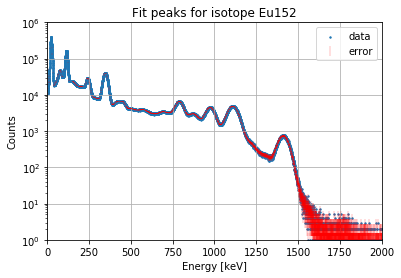

In [199]:
# plot one spectrum with peaks
for isotope in df_peaks['isotope'].unique():
    print(f'Doing isotope: {isotope}')
    this_spec = df_peaks[ df_peaks['isotope'] == isotope ]
    s = df.loc[:,isotope]

    x = df['Energy_gauss'].values

    #  one spectrum 
    plt.scatter(x, s.values, s=2, label='data')

    plt.errorbar(x, s.values, np.sqrt(s.values)/2, xerr=None, fmt='none', ecolor="red", elinewidth=0.25, label='error')
    plt.yscale('log')
    plt.title(f'Fit peaks for isotope {isotope}')
    plt.xlabel('Energy [keV]')
    plt.ylabel('Counts')
    plt.xlim(0, 2000)
    plt.ylim(1e0, 1e6)
    plt.legend()
    plt.grid()
    plt.savefig(f'{spectrum_folder}/spectrum.calibrated.isotope_{isotope}.png', dpi=600)

    plt.show()
    plt.close()